In [74]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

np.random.seed(42)

import os
for dirname, _, filenames in os.walk('/kaggle/input/titanic'):
    filenames = [os.path.join(dirname, filename) for filename in filenames]

print(filenames)

train_csv = filenames[1]
submission_csv = filenames[2]
test_csv = filenames[0]

['/kaggle/input/titanic/test.csv', '/kaggle/input/titanic/train.csv', '/kaggle/input/titanic/gender_submission.csv']


In [75]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)
submission_df = pd.read_csv(submission_csv)

In [76]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [77]:
df_cols = train_df.columns.values
df_cols

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [78]:
df_cols = ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']
train_df = train_df[df_cols]
train_df.head()


,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S


In [79]:
test_df = test_df[df_cols[1:]]
test_df.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,3,male,0,0,7.8292,Q
1,3,female,1,0,7.0000,S
2,2,male,0,0,9.6875,Q
3,3,male,0,0,8.6625,S
4,3,female,1,1,12.2875,S


**Class Balancing**

In [80]:
sample_list = train_df['Survived'].value_counts().values
class_data = {
        0 : sample_list[0],
        1 : sample_list[1]
            }


class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_df['Survived'].values),
                                                 train_df['Survived'].values)
class_weights = {i : class_weights[i] for i in [0,1]}
class_weights

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1
 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0
 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1
 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0
 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0
 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0
 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0
 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 

{0: 0.8114754098360656, 1: 1.3026315789473684}

In [81]:
categorical_columns = ['Pclass', 'Sex', 'Embarked']
def onehot_encoding(df, categorical_columns=categorical_columns):
    for column in categorical_columns:
        one_hot = pd.get_dummies(df[column])
        df = df.drop(column,axis = 1)
        df = df.join(one_hot)
    return df

In [82]:
train_df = onehot_encoding(train_df)
train_df.head()

,Survived,SibSp,Parch,Fare,1,2,3,female,male,C,Q,S
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,1,0,0,1,0,0,0,1
4,0,0,0,8.0500,0,0,1,0,1,0,0,1


In [83]:
test_df = onehot_encoding(test_df)
test_df.head()

,SibSp,Parch,Fare,1,2,3,female,male,C,Q,S
0,0,0,7.8292,0,0,1,0,1,0,1,0
1,1,0,7.0000,0,0,1,1,0,0,0,1
2,0,0,9.6875,0,1,0,0,1,0,1,0
3,0,0,8.6625,0,0,1,0,1,0,0,1
4,1,1,12.2875,0,0,1,1,0,0,0,1


In [134]:
train_df.isnull().values.any()

False

In [135]:
test_df.isnull().values.any()

True

In [137]:
test_df.isna().any()

SibSp     False
Parch     False
Fare       True
1         False
2         False
3         False
female    False
male      False
C         False
Q         False
S         False
dtype: bool

In [139]:
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].mean())
test_df.isna().any()

SibSp     False
Parch     False
Fare      False
1         False
2         False
3         False
female    False
male      False
C         False
Q         False
S         False
dtype: bool

In [140]:
X = train_df[train_df.columns.values[1:]].values
Y = train_df[train_df.columns.values[0]].values
Xtest = test_df[test_df.columns.values]
                
print(X.shape)
print(Y.shape)
print(Xtest.shape)

(891, 11)
(891,)
(418, 11)


In [141]:
# encoder = StandardScaler()
# encoder.fit(X)

# X = encoder.transform(X)
# Xtest = encoder.transform(Xtest)

**Model 1**

In [142]:
num_epoches = 80
batch_size = 16
val_split = 0.1
lr = 0.0001

In [143]:
def classifier1():
    n_features = X.shape[1]
    inputs = Input(shape=(n_features,))
    x = Dense(128, activation='relu')(inputs)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(lr),
        metrics=['accuracy']
    )
    history = model.fit(
                    X,
                    Y,
                    batch_size=batch_size,
                    epochs=num_epoches,
                    validation_split=val_split,
                    class_weight=class_weights
                    )
    return history, model


In [144]:
def plot_metrics(history):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    
    loss_train = np.cumsum(loss_train) / np.arange(1,num_epoches+1)
    loss_val = np.cumsum(loss_val) / np.arange(1,num_epoches+1)
    plt.plot(loss_train, 'r', label='Training loss')
    plt.plot(loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    acc_train = history.history['accuracy']
    acc_val = history.history['val_accuracy']
    
    plt.plot(acc_train, 'r', label='Training Accuracy')
    plt.plot(acc_val, 'b', label='validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [145]:
history1, model1 = classifier1()

Epoch 1/80
51/51 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.6167 - val_loss: nan - val_accuracy: 0.6222
Epoch 2/80
51/51 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.6155 - val_loss: nan - val_accuracy: 0.6222
Epoch 3/80
51/51 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.6155 - val_loss: nan - val_accuracy: 0.6222
Epoch 4/80
51/51 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.6155 - val_loss: nan - val_accuracy: 0.6222
Epoch 5/80
51/51 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.6155 - val_loss: nan - val_accuracy: 0.6222
Epoch 6/80
51/51 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.6155 - val_loss: nan - val_accuracy: 0.6222
Epoch 7/80
51/51 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.6155 - val_loss: nan - val_accuracy: 0.6222
Epoch 8/80
51/51 [==============================] - 0s 3ms/ste

Epoch 62/80
51/51 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.6155 - val_loss: nan - val_accuracy: 0.6222
Epoch 63/80
51/51 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.6155 - val_loss: nan - val_accuracy: 0.6222
Epoch 64/80
51/51 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.6155 - val_loss: nan - val_accuracy: 0.6222
Epoch 65/80
51/51 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.6155 - val_loss: nan - val_accuracy: 0.6222
Epoch 66/80
51/51 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.6155 - val_loss: nan - val_accuracy: 0.6222
Epoch 67/80
51/51 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.6155 - val_loss: nan - val_accuracy: 0.6222
Epoch 68/80
51/51 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.6155 - val_loss: nan - val_accuracy: 0.6222
Epoch 69/80
51/51 [==============================] - 0s

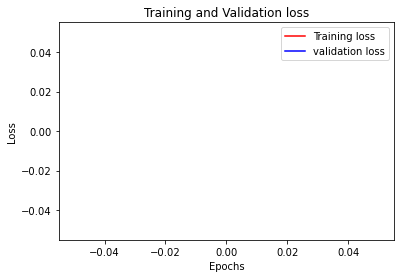

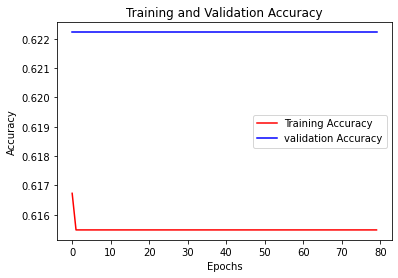

In [146]:
plot_metrics(history1)

**As you can see DNN model fails to perform the task.The main Reason is that less amount of data. So now handle 
  the task with random forest model**

In [147]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=val_split, random_state=42)

def rf_model(depth):
    model2 = RandomForestClassifier(max_depth=depth, random_state=42)
    model2.fit(Xtrain, Ytrain)
    return model2

In [148]:
from sklearn.metrics import accuracy_score
def evaluate(model2, Xtrain, Ytrain):
    Ypred = model2.predict(Xtrain)
    return accuracy_score(Ytrain, Ypred)

In [149]:
depths = [8, 12, 16, 24, 32, 40, 48]
for depth in depths:
    model2 = rf_model(depth)
    train_acc = evaluate(model2, Xtrain, Ytrain)
    val_acc = evaluate(model2, Xval, Yval)
    print("depth : ",depth)
    print("train accuracy : ",train_acc)
    print("Validation accuracy : ",val_acc)
    print("\n")

depth :  8
train accuracy :  0.8963795255930087
Validation accuracy :  0.8


depth :  12
train accuracy :  0.9250936329588015
Validation accuracy :  0.8111111111111111


depth :  16
train accuracy :  0.9275905118601748
Validation accuracy :  0.7888888888888889


depth :  24
train accuracy :  0.9275905118601748
Validation accuracy :  0.8111111111111111


depth :  32
train accuracy :  0.9275905118601748
Validation accuracy :  0.8111111111111111


depth :  40
train accuracy :  0.9275905118601748
Validation accuracy :  0.8111111111111111


depth :  48
train accuracy :  0.9275905118601748
Validation accuracy :  0.8111111111111111




**So as the proper depth we can use 24**

In [153]:
model2 = rf_model(24)
Ypred = model2.predict(Xtest)

submission_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [154]:
submission_df['Survived'] = Ypred
submission_df.to_csv('/kaggle/working/submission.csv', index=False)